In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import warnings

import numpy as np
import xarray as xr
from xgcm import Grid

import matplotlib.pyplot as plt

In [41]:
import xwmt
import xwmb

### Load grids and data

In [42]:
gridname = "natv"
lam = "heat"
dts = ["monthly", "daily", "hourly"]
wmbs = {dt: xr.open_dataset(f"/work/hfd/codedev/xwmb/data/budget_{lam}_{dt}_{gridname}.nc").mean('time') for dt in dts}

In [45]:
toSv = 1e-6/1035.

def plot_budget(wmbs):
    fig, axes = plt.subplots(3,3, figsize=(14, 10))
    for i, dt in enumerate(wmbs.keys()):
        ds = wmbs[dt]
        ax = axes[0][i]
        vmass_tendency = [v for v in ds.data_vars if 'mass_tendency' in v][0]
        (ds[vmass_tendency]*toSv).plot(ax=ax, x="thetao_l", label=r"$\partial_{t}\mathcal{V}$")
        (-ds['overturning']*toSv).plot(ax=ax, x="thetao_l", label=r"-$\Psi$")
        (ds['external_forcing']*toSv).plot(ax=ax, x="thetao_l", label=r"$\mathcal{G}_{surf}$")
        (ds['diffusion']*toSv).plot(ax=ax, x="thetao_l", label=r"$\mathcal{G}_{diff}$")
        numerical_mixing = ds.advection - (-ds.overturning)
        tendency_error = (-ds.total_tendency) - ds[vmass_tendency]
        numerical_errors = numerical_mixing + tendency_error
        (numerical_errors*toSv).plot(ax=ax, x="thetao_l", label=r"$\mathcal{N}$")
        ax.grid(True, alpha=0.1)
        ax.set_xlim(-1, 22)
        ax.set_ylim(-0.8, 0.8)
        ax.set_xlabel("")
        ax.set_title(f"Water Mass Budget with {dt}-mean diags")
        if i==0:
            ax.legend()
            ax.set_ylabel("Transformation Rate [Sv]")
        
            
        ax = axes[1][i]
        (tendency_error*toSv).plot(ax=ax, x="thetao_l", label=r"$\mathcal{N} \equiv \mathcal{N}_{D} + \mathcal{N}_{A}$", color="C4", linestyle="--", alpha=0.5)
        (numerical_mixing*toSv).plot(ax=ax, x="thetao_l", label=r"$\mathcal{N}_{A} \equiv \mathcal{G}_{adv} - (-\Psi)$", color="C4", linestyle=":", alpha=0.5)
        (numerical_errors*toSv).plot(ax=ax, x="thetao_l", label=r"$\mathcal{N}_{D} \equiv -\mathcal{G}_{tend} - \partial_{t}\mathcal{V}$", color="C4")
        if i==0:
            ax.legend()
            ax.set_ylabel("Transformation Rate [Sv]")
        ax.grid(True, alpha=0.1)
        ax.set_xlim(-1, 22)
        ax.set_ylim(-0.8, 0.8)
        ax.set_xlabel("")
        
            
        ax = axes[2][i]
        residual = (
            ds[vmass_tendency] -
            ds['overturning'] +
            ds['external_forcing'] +
            ds['diffusion'] +
            numerical_errors
        )
        (residual*toSv).plot(
            ax=ax,
            label=r"$\mathcal{R} = \partial_{t}\mathcal{V} - \Psi + \mathcal{G}_{surf} + \mathcal{G}_{diff} + \mathcal{N} \simeq 0$",
            color="k"
        )
        if i==0:
            ax.legend()
            ax.set_ylabel("Transformation Rate [Sv]")
        ax.grid(True, alpha=0.1)
        ax.set_xlim(-1, 22)
        ax.set_xlabel(r"potential temperature [$\degree$C]")
        
    plt.tight_layout()

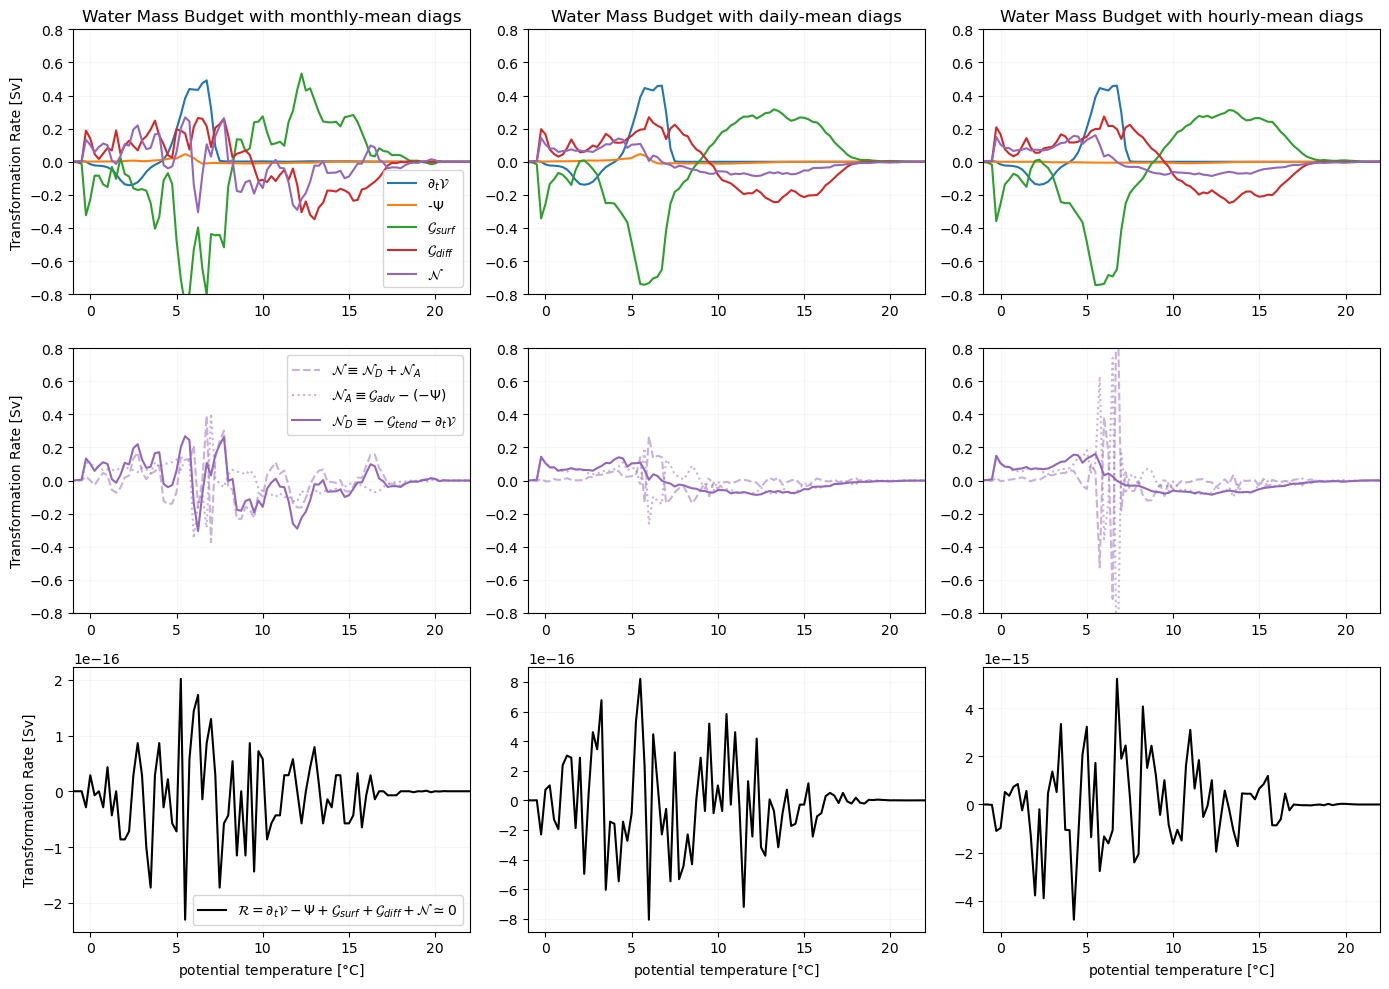

In [46]:
plot_budget(wmbs)
plt.savefig("../figures/offline_sensitivity.png", bbox_inches="tight", dpi=150)